In [0]:
import numpy as np
import torch.nn as nn
import torch
import os
import zipfile
import pickle
import fnmatch
import json
import string

from collections import Counter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import time
from tqdm import tqdm
from drlstm.utils import correct_predictions


from torch.utils.data import DataLoader
from drlstm.data import NLIDataset
from drlstm.model import DRLSTM

import matplotlib.pyplot as plt


In [0]:
#!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

In [0]:
#!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip

--2019-11-27 22:53:49--  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94550081 (90M) [application/zip]
Saving to: ‘snli_1.0.zip’

snli_1.0.zip        100%[===================>]  90.17M  18.1MB/s    in 7.9s    

2019-11-27 22:53:58 (11.5 MB/s) - ‘snli_1.0.zip’ saved [94550081/94550081]



In [0]:
#!unzip snli_1.0.zip

In [0]:
# Mount Google Drive (to save the downloaded files)
#from google.colab import drive
#drive.mount('/gdrive')

# Copy word vectors *to* Google Drive
# You only need to do this once.
# Please comment this out after running it. 
#!cp "glove.840B.300d.zip" "/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# If you copied the word vectors to your Drive before,
# here is where you copy them back to the Colab notebook.

# Copy Glove vectors *from* Google Drive
#!cp "/gdrive/My Drive/glove.840B.300d.zip" .

In [0]:
#!unzip glove*.zip

In [0]:
"""
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.840B.300d.txt', encoding='utf-8')

for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
"""

Indexing word vectors.
Found 2196016 word vectors.


In [0]:
"""
Preprocessor and dataset definition for NLI.
"""
# Aurelien Coet, 2018.

class Preprocessor(object):
    """
    Preprocessor class for Natural Language Inference datasets.

    The class can be used to read NLI datasets, build worddicts for them
    and transform their premises, hypotheses and labels into lists of
    integer indices.
    """

    def __init__(self,
                 lowercase=False,
                 ignore_punctuation=False,
                 num_words=None,
                 stopwords=[],
                 labeldict={},
                 bos=None,
                 eos=None):

        self.lowercase = lowercase
        self.ignore_punctuation = ignore_punctuation
        self.num_words = num_words
        self.stopwords = stopwords
        self.labeldict = labeldict
        self.bos = bos
        self.eos = eos

    def read_data(self, filepath):
        """
        Read the premises, hypotheses and labels from some NLI dataset's
        file and return them in a dictionary. The file should be in the same
        form as SNLI's .txt files.

        Args:
            filepath: The path to a file containing some premises, hypotheses
                and labels that must be read. The file should be formatted in
                the same way as the SNLI (and MultiNLI) dataset.

        Returns:
            A dictionary containing three lists, one for the premises, one for
            the hypotheses, and one for the labels in the input data.
        """
        with open(filepath, "r", encoding="utf8") as input_data:
            ids, premises, hypotheses, labels = [], [], [], []

            # Translation tables to remove parentheses and punctuation from
            # strings.
            parentheses_table = str.maketrans({"(": None, ")": None})
            punct_table = str.maketrans({key: " "
                                         for key in string.punctuation})

            # Ignore the headers on the first line of the file.
            next(input_data)

            for line in input_data:
                line = line.strip().split("\t")

                # Ignore sentences that have no gold label.
                if line[0] == "-":
                    continue

                pair_id = line[7]
                premise = line[1]
                hypothesis = line[2]

                # Remove '(' and ')' from the premises and hypotheses.
                premise = premise.translate(parentheses_table)
                hypothesis = hypothesis.translate(parentheses_table)

                if self.lowercase:
                    premise = premise.lower()
                    hypothesis = hypothesis.lower()

                if self.ignore_punctuation:
                    premise = premise.translate(punct_table)
                    hypothesis = hypothesis.translate(punct_table)

                # Each premise and hypothesis is split into a list of words.
                premises.append([w for w in premise.rstrip().split()
                                 if w not in self.stopwords])
                hypotheses.append([w for w in hypothesis.rstrip().split()
                                   if w not in self.stopwords])
                labels.append(line[0])
                ids.append(pair_id)

            return {"ids": ids,
                    "premises": premises,
                    "hypotheses": hypotheses,
                    "labels": labels}

    def build_worddict(self, data):
        """
        Build a dictionary associating words to unique integer indices for
        some dataset. The worddict can then be used to transform the words
        in datasets to their indices.

        Args:
            data: A dictionary containing the premises, hypotheses and
                labels of some NLI dataset, in the format returned by the
                'read_data' method of the Preprocessor class.
        """
        words = []
        [words.extend(sentence) for sentence in data["premises"]]
        [words.extend(sentence) for sentence in data["hypotheses"]]

        counts = Counter(words)
        num_words = self.num_words
        if self.num_words is None:
            num_words = len(counts)

        self.worddict = {}

        # Special indices are used for padding, out-of-vocabulary words, and
        # beginning and end of sentence tokens.
        self.worddict["_PAD_"] = 0
        self.worddict["_OOV_"] = 1

        offset = 2
        if self.bos:
            self.worddict["_BOS_"] = 2
            offset += 1
        if self.eos:
            self.worddict["_EOS_"] = 3
            offset += 1

        for i, word in enumerate(counts.most_common(num_words)):
            self.worddict[word[0]] = i + offset

        if self.labeldict == {}:
            label_names = set(data["labels"])
            self.labeldict = {label_name: i
                              for i, label_name in enumerate(label_names)}

    def words_to_indices(self, sentence):
        """
        Transform the words in a sentence to their corresponding integer
        indices.

        Args:
            sentence: A list of words that must be transformed to indices.

        Returns:
            A list of indices.
        """
        indices = []
        # Include the beggining of sentence token at the start of the sentence
        # if one is defined.
        if self.bos:
            indices.append(self.worddict["_BOS_"])

        for word in sentence:
            if word in self.worddict:
                index = self.worddict[word]
            else:
                # Words absent from 'worddict' are treated as a special
                # out-of-vocabulary word (OOV).
                index = self.worddict["_OOV_"]
            indices.append(index)
        # Add the end of sentence token at the end of the sentence if one
        # is defined.
        if self.eos:
            indices.append(self.worddict["_EOS_"])

        return indices

    def indices_to_words(self, indices):
        """
        Transform the indices in a list to their corresponding words in
        the object's worddict.

        Args:
            indices: A list of integer indices corresponding to words in
                the Preprocessor's worddict.

        Returns:
            A list of words.
        """
        return [list(self.worddict.keys())[list(self.worddict.values())
                                           .index(i)]
                for i in indices]

    def transform_to_indices(self, data):
        """
        Transform the words in the premises and hypotheses of a dataset, as
        well as their associated labels, to integer indices.

        Args:
            data: A dictionary containing lists of premises, hypotheses
                and labels, in the format returned by the 'read_data'
                method of the Preprocessor class.

        Returns:
            A dictionary containing the transformed premises, hypotheses and
            labels.
        """
        transformed_data = {"ids": [],
                            "premises": [],
                            "hypotheses": [],
                            "labels": []}

        for i, premise in enumerate(data["premises"]):
            # Ignore sentences that have a label for which no index was
            # defined in 'labeldict'.
            label = data["labels"][i]
            if label not in self.labeldict and label != "hidden":
                continue

            transformed_data["ids"].append(data["ids"][i])

            if label == "hidden":
                transformed_data["labels"].append(-1)
            else:
                transformed_data["labels"].append(self.labeldict[label])

            indices = self.words_to_indices(premise)
            transformed_data["premises"].append(indices)

            indices = self.words_to_indices(data["hypotheses"][i])
            transformed_data["hypotheses"].append(indices)

        return transformed_data

    def build_embedding_matrix(self, embeddings_file):
        """
        Build an embedding matrix with pretrained weights for object's
        worddict.

        Args:
            embeddings_file: A file containing pretrained word embeddings.

        Returns:
            A numpy matrix of size (num_words+n_special_tokens, embedding_dim)
            containing pretrained word embeddings (the +n_special_tokens is for
            the padding and out-of-vocabulary tokens, as well as BOS and EOS if
            they're used).
        """
        # Load the word embeddings in a dictionnary.
        embeddings = {}
        with open(embeddings_file, "r", encoding="utf8") as input_data:
            for line in input_data:
                line = line.split()

                try:
                    # Check that the second element on the line is the start
                    # of the embedding and not another word. Necessary to
                    # ignore multiple word lines.
                    float(line[1])
                    word = line[0]
                    if word in self.worddict:
                        embeddings[word] = line[1:]

                # Ignore lines corresponding to multiple words separated
                # by spaces.
                except ValueError:
                    continue

        num_words = len(self.worddict)
        embedding_dim = len(list(embeddings.values())[0])
        embedding_matrix = np.zeros((num_words, embedding_dim))

        # Actual building of the embedding matrix.
        missed = 0
        for word, i in self.worddict.items():
            if word in embeddings:
                embedding_matrix[i] = np.array(embeddings[word], dtype=float)
            else:
                if word == "_PAD_":
                    continue
                missed += 1
                # Out of vocabulary words are initialised with random gaussian
                # samples.
                embedding_matrix[i] = np.random.normal(size=(embedding_dim))
        print("Missed words: ", missed)

        return embedding_matrix


class NLIDataset(Dataset):
    """
    Dataset class for Natural Language Inference datasets.

    The class can be used to read preprocessed datasets where the premises,
    hypotheses and labels have been transformed to unique integer indices
    (this can be done with the 'preprocess_data' script in the 'scripts'
    folder of this repository).
    """

    def __init__(self,
                 data,
                 padding_idx=0,
                 max_premise_length=None,
                 max_hypothesis_length=None):
        """
        Args:
            data: A dictionary containing the preprocessed premises,
                hypotheses and labels of some dataset.
            padding_idx: An integer indicating the index being used for the
                padding token in the preprocessed data. Defaults to 0.
            max_premise_length: An integer indicating the maximum length
                accepted for the sequences in the premises. If set to None,
                the length of the longest premise in 'data' is used.
                Defaults to None.
            max_hypothesis_length: An integer indicating the maximum length
                accepted for the sequences in the hypotheses. If set to None,
                the length of the longest hypothesis in 'data' is used.
                Defaults to None.
        """
        self.premises_lengths = [len(seq) for seq in data["premises"]]
        self.max_premise_length = max_premise_length
        if self.max_premise_length is None:
            self.max_premise_length = max(self.premises_lengths)

        self.hypotheses_lengths = [len(seq) for seq in data["hypotheses"]]
        self.max_hypothesis_length = max_hypothesis_length
        if self.max_hypothesis_length is None:
            self.max_hypothesis_length = max(self.hypotheses_lengths)

        self.num_sequences = len(data["premises"])

        self.data = {"ids": [],
                     "premises": torch.ones((self.num_sequences,
                                             self.max_premise_length),
                                            dtype=torch.long) * padding_idx,
                     "hypotheses": torch.ones((self.num_sequences,
                                               self.max_hypothesis_length),
                                              dtype=torch.long) * padding_idx,
                     "labels": torch.tensor(data["labels"], dtype=torch.long)}

        for i, premise in enumerate(data["premises"]):
            self.data["ids"].append(data["ids"][i])
            end = min(len(premise), self.max_premise_length)
            self.data["premises"][i][:end] = torch.tensor(premise[:end])

            hypothesis = data["hypotheses"][i]
            end = min(len(hypothesis), self.max_hypothesis_length)
            self.data["hypotheses"][i][:end] = torch.tensor(hypothesis[:end])

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, index):
        return {"id": self.data["ids"][index],
                "premise": self.data["premises"][index],
                "premise_length": min(self.premises_lengths[index],
                                      self.max_premise_length),
                "hypothesis": self.data["hypotheses"][index],
                "hypothesis_length": min(self.hypotheses_lengths[index],
                                         self.max_hypothesis_length),
                "label": self.data["labels"][index]}


In [0]:
# fetch_data.py
"""
Fetch datasets and pretrained word embeddings for the model.

By default, the script downloads the following.
    - The SNLI corpus;
    - GloVe word embeddings (840B - 300d).
"""
# Aurelien Coet, 2018.

def download(url, targetdir):
    """
    Download a file and save it in some target directory.

    Args:
        url: The url from which the file must be downloaded.
        targetdir: The path to the directory where the file must be saved.

    Returns:
        The path to the downloaded file.
    """
    print("* Downloading data from {}...".format(url))
    filepath = os.path.join(targetdir, url.split('/')[-1])
    !wget.download(url, filepath)
    return filepath


def unzip(filepath):
    """
    Extract the data from a zipped file and delete the archive.

    Args:
        filepath: The path to the zipped file.
    """
    print("\n* Extracting: {}...".format(filepath))
    dirpath = os.path.dirname(filepath)
    with zipfile.ZipFile(filepath) as zf:
        for name in zf.namelist():
            # Ignore useless files in archives.
            if "__MACOSX" in name or\
               ".DS_Store" in name or\
               "Icon" in name:
                continue
            zf.extract(name, dirpath)
    # Delete the archive once the data has been extracted.
    os.remove(filepath)


def download_unzip(url, targetdir):
    """
    Download and unzip data from some url and save it in a target directory.

    Args:
        url: The url to download the data from.
        targetdir: The target directory in which to download and unzip the
                   data.
    """
    filepath = os.path.join(targetdir, url.split('/')[-1])
    target = os.path.join(targetdir,
                          ".".join((url.split('/')[-1]).split('.')[:-1]))

    if not os.path.exists(targetdir):
        print("* Creating target directory {}...".format(targetdir))
        os.makedirs(targetdir)

    # Skip download and unzipping if the unzipped data is already available.
    if os.path.exists(target) or os.path.exists(target + ".txt"):
        print("* Found unzipped data in {}, skipping download and unzip..."
              .format(targetdir))
    # Skip downloading if the zipped data is already available.
    elif os.path.exists(filepath):
        print("* Found zipped data in {} - skipping download..."
              .format(targetdir))
        unzip(filepath)
    # Download and unzip otherwise.
    else:
        unzip(download(url, targetdir))

# Default data.
snli_url = "https://nlp.stanford.edu/projects/snli/snli_1.0.zip"
glove_url = "http://www-nlp.stanford.edu/data/glove.840B.300d.zip"


dataset_url = snli_url
embeddings_url = glove_url
target_dir = os.path.join(".", "data")

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

print(20*"=", "Fetching the dataset:", 20*'=')
download_unzip(dataset_url, os.path.join(target_dir, "dataset"))

print(20*"=", "Fetching the word embeddings:", 20*"=")
download_unzip(embeddings_url,
                os.path.join(target_dir, "embeddings"))


In [0]:
"""
Preprocess the SNLI dataset and word embeddings to be used by the model.
"""
# Aurelien Coet, 2018.

def preprocess_SNLI_data(inputdir,
                         embeddings_file,
                         targetdir,
                         lowercase=False,
                         ignore_punctuation=False,
                         num_words=None,
                         stopwords=[],
                         labeldict={},
                         bos=None,
                         eos=None):

    if not os.path.exists(targetdir):
        os.makedirs(targetdir)

    # Retrieve the train, dev and test data files from the dataset directory.
    train_file = ""
    dev_file = ""
    test_file = ""
    for file in os.listdir(inputdir):
        if fnmatch.fnmatch(file, "*_train.txt"):
            train_file = file
        elif fnmatch.fnmatch(file, "*_dev.txt"):
            dev_file = file
        elif fnmatch.fnmatch(file, "*_test.txt"):
            test_file = file

    # -------------------- Train data preprocessing -------------------- #
    preprocessor = Preprocessor(lowercase=lowercase,
                                ignore_punctuation=ignore_punctuation,
                                num_words=num_words,
                                stopwords=stopwords,
                                labeldict=labeldict,
                                bos=bos,
                                eos=eos)

    print(20*"=", " Preprocessing train set ", 20*"=")
    print("\t* Reading data...")
    data = preprocessor.read_data(os.path.join(inputdir, train_file))

    print("\t* Computing worddict and saving it...")
    preprocessor.build_worddict(data)
    with open(os.path.join(targetdir, "worddict.pkl"), "wb") as pkl_file:
        pickle.dump(preprocessor.worddict, pkl_file)

    print("\t* Transforming words in premises and hypotheses to indices...")
    transformed_data = preprocessor.transform_to_indices(data)
    print("\t* Saving result...")
    with open(os.path.join(targetdir, "train_data.pkl"), "wb") as pkl_file:
        pickle.dump(transformed_data, pkl_file)

    # -------------------- Validation data preprocessing -------------------- #
    print(20*"=", " Preprocessing dev set ", 20*"=")
    print("\t* Reading data...")
    data = preprocessor.read_data(os.path.join(inputdir, dev_file))

    print("\t* Transforming words in premises and hypotheses to indices...")
    transformed_data = preprocessor.transform_to_indices(data)
    print("\t* Saving result...")
    with open(os.path.join(targetdir, "dev_data.pkl"), "wb") as pkl_file:
        pickle.dump(transformed_data, pkl_file)

    # -------------------- Test data preprocessing -------------------- #
    print(20*"=", " Preprocessing test set ", 20*"=")
    print("\t* Reading data...")
    data = preprocessor.read_data(os.path.join(inputdir, test_file))

    print("\t* Transforming words in premises and hypotheses to indices...")
    transformed_data = preprocessor.transform_to_indices(data)
    print("\t* Saving result...")
    with open(os.path.join(targetdir, "test_data.pkl"), "wb") as pkl_file:
        pickle.dump(transformed_data, pkl_file)

    # -------------------- Embeddings preprocessing -------------------- #
    print(20*"=", " Preprocessing embeddings ", 20*"=")
    print("\t* Building embedding matrix and saving it...")
    embed_matrix = preprocessor.build_embedding_matrix(embeddings_file)
    with open(os.path.join(targetdir, "embeddings.pkl"), "wb") as pkl_file:
        pickle.dump(embed_matrix, pkl_file)


In [0]:
default_config = "/content/config/preprocessing/snli_preprocessing.json"

config = default_config
script_dir = "/"

if config == default_config:
    config_path = os.path.join(script_dir, config)
else:
    config_path = config

with open(os.path.normpath(config_path), "r") as cfg_file:
    config = json.load(cfg_file)

preprocess_SNLI_data(
    os.path.normpath(os.path.join(script_dir, config["data_dir"])),
    os.path.normpath(os.path.join(script_dir, config["embeddings_file"])),
    os.path.normpath(os.path.join(script_dir, config["target_dir"])),
    lowercase=config["lowercase"],
    ignore_punctuation=config["ignore_punctuation"],
    num_words=config["num_words"],
    stopwords=config["stopwords"],
    labeldict=config["labeldict"],
    bos=config["bos"],
    eos=config["eos"]
)

====================  Preprocessing train set  ====================
	* Reading data...
	* Computing worddict and saving it...
	* Transforming words in premises and hypotheses to indices...
	* Saving result...
====================  Preprocessing dev set  ====================
	* Reading data...
	* Transforming words in premises and hypotheses to indices...
	* Saving result...
====================  Preprocessing test set  ====================
	* Reading data...
	* Transforming words in premises and hypotheses to indices...
	* Saving result...
====================  Preprocessing embeddings  ====================
	* Building embedding matrix and saving it...
Missed words:  4045


In [0]:
"""
Utility functions for training and validating models.
"""
def train(model,
          dataloader,
          optimizer,
          criterion,
          epoch_number,
          max_gradient_norm):

    # Switch the model to train mode.
    model.train()
    device = model.device

    epoch_start = time.time()
    batch_time_avg = 0.0
    running_loss = 0.0
    correct_preds = 0

    tqdm_batch_iterator = tqdm(dataloader)
    for batch_index, batch in enumerate(tqdm_batch_iterator):
        batch_start = time.time()

        # Move input and output data to the GPU if it is used.
        premises = batch["premise"].to(device)
        premises_lengths = batch["premise_length"].to(device)
        hypotheses = batch["hypothesis"].to(device)
        hypotheses_lengths = batch["hypothesis_length"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        logits, probs = model(premises,
                              premises_lengths,
                              hypotheses,
                              hypotheses_lengths)
        loss = criterion(logits, labels)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_gradient_norm)
        optimizer.step()

        batch_time_avg += time.time() - batch_start
        running_loss += loss.item()
        correct_preds += correct_predictions(probs, labels)

        description = "Avg. batch proc. time: {:.4f}s, loss: {:.4f}"\
                      .format(batch_time_avg/(batch_index+1),
                              running_loss/(batch_index+1))
        tqdm_batch_iterator.set_description(description)

    epoch_time = time.time() - epoch_start
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_preds / len(dataloader.dataset)

    return epoch_time, epoch_loss, epoch_accuracy


def validate(model, dataloader, criterion):
    # Switch to evaluate mode.
    model.eval()
    device = model.device

    epoch_start = time.time()
    running_loss = 0.0
    running_accuracy = 0.0

    # Deactivate autograd for evaluation.
    with torch.no_grad():
        for batch in dataloader:
            # Move input and output data to the GPU if one is used.
            premises = batch["premise"].to(device)
            premises_lengths = batch["premise_length"].to(device)
            hypotheses = batch["hypothesis"].to(device)
            hypotheses_lengths = batch["hypothesis_length"].to(device)
            labels = batch["label"].to(device)

            logits, probs = model(premises,
                                  premises_lengths,
                                  hypotheses,
                                  hypotheses_lengths)
            loss = criterion(logits, labels)

            running_loss += loss.item()
            running_accuracy += correct_predictions(probs, labels)

    epoch_time = time.time() - epoch_start
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_accuracy / (len(dataloader.dataset))

    return epoch_time, epoch_loss, epoch_accuracy


In [0]:
"""
Train the model on the preprocessed SNLI dataset.
"""
# Aurelien Coet, 2018.

from drlstm.data import NLIDataset

def main(train_file,
         valid_file,
         embeddings_file,
         target_dir,
         hidden_size=300,
         dropout=0.5,
         num_classes=3,
         epochs=1,
         batch_size=32,
         lr=0.0004,
         patience=5,
         max_grad_norm=10.0,
         checkpoint=None):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print(20 * "=", " Preparing for training ", 20 * "=")

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # -------------------- Data loading ------------------- #
    print("\t* Loading training data...")
    with open(train_file, "rb") as pkl:
        train_data = NLIDataset(pickle.load(pkl))

    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    print("\t* Loading validation data...")
    with open(valid_file, "rb") as pkl:
        valid_data = NLIDataset(pickle.load(pkl))

    valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

    # -------------------- Model definition ------------------- #
    print("\t* Building model...")
    with open(embeddings_file, "rb") as pkl:
        embeddings = torch.tensor(pickle.load(pkl), dtype=torch.float)\
                     .to(device)

    model = DRLSTM(embeddings.shape[0],
                 embeddings.shape[1],
                 hidden_size,
                 embeddings=embeddings,
                 dropout=dropout,
                 num_classes=num_classes,
                 device=device).to(device)

    # -------------------- Preparation for training  ------------------- #
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           mode="max",
                                                           factor=0.5,
                                                           patience=0)

    best_score = 0.0
    start_epoch = 1

    # Data for loss curves plot.
    epochs_count = []
    train_losses = []
    valid_losses = []

    # Continuing training from a checkpoint if one was given as argument.
    if checkpoint:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint["epoch"] + 1
        best_score = checkpoint["best_score"]

        print("\t* Training will continue on existing model from epoch {}..."
              .format(start_epoch))

        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        epochs_count = checkpoint["epochs_count"]
        train_losses = checkpoint["train_losses"]
        valid_losses = checkpoint["valid_losses"]

    # Compute loss and accuracy before starting (or resuming) training.
    _, valid_loss, valid_accuracy = validate(model,
                                             valid_loader,
                                             criterion)
    print("\t* Validation loss before training: {:.4f}, accuracy: {:.4f}%"
          .format(valid_loss, (valid_accuracy*100)))

    # -------------------- Training epochs ------------------- #
    print("\n",
          20 * "=",
          "Training model on device: {}".format(device),
          20 * "=")

    patience_counter = 0
    for epoch in range(start_epoch, epochs+1):
        epochs_count.append(epoch)

        print("* Training epoch {}:".format(epoch))
        epoch_time, epoch_loss, epoch_accuracy = train(model,
                                                       train_loader,
                                                       optimizer,
                                                       criterion,
                                                       epoch,
                                                       max_grad_norm)

        train_losses.append(epoch_loss)
        print("-> Training time: {:.4f}s, loss = {:.4f}, accuracy: {:.4f}%"
              .format(epoch_time, epoch_loss, (epoch_accuracy*100)))

        print("* Validation for epoch {}:".format(epoch))
        epoch_time, epoch_loss, epoch_accuracy = validate(model,
                                                          valid_loader,
                                                          criterion)

        valid_losses.append(epoch_loss)
        print("-> Valid. time: {:.4f}s, loss: {:.4f}, accuracy: {:.4f}%\n"
              .format(epoch_time, epoch_loss, (epoch_accuracy*100)))

        # Update the optimizer's learning rate with the scheduler.
        scheduler.step(epoch_accuracy)

        # Early stopping on validation accuracy.
        if epoch_accuracy < best_score:
            patience_counter += 1
        else:
            best_score = epoch_accuracy
            patience_counter = 0
            # Save the best model. The optimizer is not saved to avoid having
            # a checkpoint file that is too heavy to be shared. To resume
            # training from the best model, use the 'drlstm_*.pth.tar'
            # checkpoints instead.
            torch.save({"epoch": epoch,
                        "model": model.state_dict(),
                        "best_score": best_score,
                        "epochs_count": epochs_count,
                        "train_losses": train_losses,
                        "valid_losses": valid_losses},
                       os.path.join(target_dir, "best.pth.tar"))

        # Save the model at each epoch.
        print ('Saving model to')
        print (os.path.join(target_dir, "drlstm_{}.pth.tar".format(epoch)))
        torch.save({"epoch": epoch,
                    "model": model.state_dict(),
                    "best_score": best_score,
                    "optimizer": optimizer.state_dict(),
                    "epochs_count": epochs_count,
                    "train_losses": train_losses,
                    "valid_losses": valid_losses},
                   os.path.join(target_dir, "drlstm_{}.pth.tar".format(epoch)))

        if patience_counter >= patience:
            print("-> Early stopping: patience limit reached, stopping...")
            break

    # Plotting of the loss curves for the train and validation sets.
    plt.figure()
    plt.plot(epochs_count, train_losses, "-r")
    plt.plot(epochs_count, valid_losses, "-b")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training loss", "Validation loss"])
    plt.title("Cross entropy loss")
    plt.show()

In [0]:
"""
Definition of the model.
"""
# Aurelien Coet, 2018.

from drlstm.layers import RNNDropout, Seq2SeqEncoder, SoftmaxAttention
from drlstm.utils import get_mask, replace_masked

class DRLSTM(nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_dim,
                 hidden_size,
                 embeddings=None,
                 padding_idx=0,
                 dropout=0.5,
                 num_classes=3,
                 device="cpu"):

        super(DRLSTM, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.dropout = dropout
        self.device = device

        self.debug = False

        self._word_embedding = nn.Embedding(self.vocab_size,
                                            self.embedding_dim,
                                            padding_idx=padding_idx,
                                            _weight=embeddings)
        #print ('embedding_dim: ')
        #print (embedding_dim)
        if self.dropout:
            self._rnn_dropout = RNNDropout(p=self.dropout)
            # self._rnn_dropout = nn.Dropout(p=self.dropout)

        self._encoding = Seq2SeqEncoder(nn.LSTM,
                                        self.embedding_dim,
                                        self.hidden_size,
                                        bidirectional=True)
        
        self._encoding1 = Seq2SeqEncoder(nn.LSTM,
                                        self.embedding_dim,
                                        int(self.hidden_size/2),
                                        bidirectional=True)
        self._encoding2 = Seq2SeqEncoder(nn.LSTM,
                                        self.hidden_size,
                                        self.hidden_size,
                                        bidirectional=True)

        self._attention = SoftmaxAttention()

        self._projection = nn.Sequential(nn.Linear(4*2*self.hidden_size,
                                                   self.hidden_size),
                                         nn.ReLU())

        self._composition = Seq2SeqEncoder(nn.LSTM,
                                           self.hidden_size,
                                           self.hidden_size,
                                           bidirectional=True)
        
        self._composition1 = Seq2SeqEncoder(nn.LSTM,
                                           self.hidden_size,
                                           self.hidden_size,
                                           bidirectional=True)
        
        self._composition2 = Seq2SeqEncoder(nn.LSTM,
                                           2*self.hidden_size,
                                           self.hidden_size,
                                           bidirectional=True)

        self._classification = nn.Sequential(nn.Dropout(p=self.dropout),
                                             nn.Linear(2*4*self.hidden_size,
                                                       self.hidden_size),
                                             nn.Tanh(),
                                             nn.Dropout(p=self.dropout),
                                             nn.Linear(self.hidden_size,
                                                       self.num_classes))

        # Initialize all weights and biases in the model.
        self.apply(_init_model_weights)

    def forward(self,
                premises,
                premises_lengths,
                hypotheses,
                hypotheses_lengths):

        premises_mask = get_mask(premises, premises_lengths).to(self.device)
        hypotheses_mask = get_mask(hypotheses, hypotheses_lengths)\
            .to(self.device)

        embedded_premises = self._word_embedding(premises)
        embedded_hypotheses = self._word_embedding(hypotheses)

        if self.debug:
          print (embedded_premises.size()) # 32,61,300
          print (embedded_hypotheses.size()) # 32,57,300
        #if self.dropout:
        #    embedded_premises = self._rnn_dropout(embedded_premises)
        #    embedded_hypotheses = self._rnn_dropout(embedded_hypotheses)


        
        encoded_premises = self._encoding(embedded_premises,
                                          premises_lengths)
        encoded_hypotheses = self._encoding(embedded_hypotheses,
                                            hypotheses_lengths)
        
        
        encoded_premises1 = self._encoding1(embedded_premises,
                                          premises_lengths)
        encoded_hypotheses1 = self._encoding1(embedded_hypotheses,
                                            hypotheses_lengths)
        
        if self.debug:
          print ('encoded_premises1')
          print (encoded_premises1.size())
          print ('encoded_hypo1')
          print (encoded_hypotheses1.size())

        encoded_premises2 = self._encoding2(encoded_hypotheses1,
                                          hypotheses_lengths)
        encoded_hypotheses2 = self._encoding2(encoded_premises1,
                                            premises_lengths)
        
        if self.debug:
          print ('encoded_premises2')
          print (encoded_premises2.size())
          print ('encoded_hypo2')
          print (encoded_hypotheses2.size())
        
        """
        encoded_premises1
        torch.Size([32, 36, 300])
        encoded_hypo1
        torch.Size([32, 22, 300])
        encoded_premises2
        torch.Size([32, 22, 600])
        encoded_hypo2
        torch.Size([32, 36, 600])
        #print (premises_lengths.size()) # 32
        #print (hypotheses_lengths.size()) # 32
        
        #print (encoded_premises.size()) # 32,36,600
        #print (encoded_hypotheses.size()) # 32,22,600

        """

        attended_premises, attended_hypotheses =\
            self._attention(encoded_premises2, hypotheses_mask,
                            encoded_hypotheses2, premises_mask)
        
        if self.debug:
          print ('after attention')
          print ('attended_premises: ')
          print (attended_premises.size())
          print ('attended_hypotheses: ')
          print (attended_hypotheses.size())

        enhanced_premises = torch.cat([encoded_premises2,
                                       attended_premises,
                                       encoded_premises2 - attended_premises,
                                       encoded_premises2 * attended_premises],
                                      dim=-1)
        enhanced_hypotheses = torch.cat([encoded_hypotheses2,
                                         attended_hypotheses,
                                         encoded_hypotheses2 -
                                         attended_hypotheses,
                                         encoded_hypotheses2 *
                                         attended_hypotheses],
                                        dim=-1)
       
        if self.debug:
          print ('enhanced_premises: ')
          print (enhanced_premises.size())
          print ('enhanced_hypotheses: ')
          print (enhanced_hypotheses.size())
        
        projected_premises = self._projection(enhanced_premises)
        projected_hypotheses = self._projection(enhanced_hypotheses)
        
        if self.debug:
          print ('projected_premises:')
          print (projected_premises.size())
          print ('projected_hypotheses:')
          print (projected_hypotheses.size())

        if self.dropout:
            projected_premises = self._rnn_dropout(projected_premises)
            projected_hypotheses = self._rnn_dropout(projected_hypotheses)

        if self.debug:
          print ('projected_premises after dropout:')
          print (projected_premises.size())
          print ('projected_hypotheses after dropout:')
          print (projected_hypotheses.size())
        """
        v_ai = self._composition(projected_premises, premises_lengths)
        v_bj = self._composition(projected_hypotheses, hypotheses_lengths)
        print ('v_ai:')
        print (v_ai.size())
        print ('v_bj')
        print (v_bj.size())
        """

        v_ai1 = self._composition1(projected_premises, hypotheses_lengths)
        v_bj1 = self._composition1(projected_hypotheses, premises_lengths)

        if self.debug:
          print ('v_ai1')
          print (v_ai1.size())
          print ('v_bj1')
          print (v_bj1.size())

        v_ai2 = self._composition2(v_ai1, hypotheses_lengths)
        v_bj2 = self._composition2(v_bj1, premises_lengths)

        if self.debug:
          print ('v_ai2')
          print (v_ai2.size())
          print ('v_bj2')
          print (v_bj2.size())

        
        # max pooling
        v_ai = torch.max(v_ai1, v_ai2)
        v_bj = torch.max(v_bj1, v_bj2)

        if self.debug:
          print ('v_ai after max')
          print (v_ai.size())
          print ('v_bj after max')
          print (v_bj.size())

        v_a_avg = torch.sum(v_bj * premises_mask.unsqueeze(1)
                                                .transpose(2, 1), dim=1)\
            / torch.sum(premises_mask, dim=1, keepdim=True)
        v_b_avg = torch.sum(v_ai * hypotheses_mask.unsqueeze(1)
                                                  .transpose(2, 1), dim=1)\
            / torch.sum(hypotheses_mask, dim=1, keepdim=True)

        v_a_max, _ = replace_masked(v_bj, premises_mask, -1e7).max(dim=1)
        v_b_max, _ = replace_masked(v_ai, hypotheses_mask, -1e7).max(dim=1)

        v = torch.cat([v_a_avg, v_a_max, v_b_avg, v_b_max], dim=1)
        if self.debug:
          print ('v:')
          print (v.size())
        logits = self._classification(v)
        if self.debug:
          print ('logits:')
          print (logits.size())
        probabilities = nn.functional.softmax(logits, dim=-1)

        return logits, probabilities


def _init_model_weights(module):
    """
    Initialise the weights of the model.
    """
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight.data)
        nn.init.constant_(module.bias.data, 0.0)

    elif isinstance(module, nn.LSTM):
        nn.init.xavier_uniform_(module.weight_ih_l0.data)
        nn.init.orthogonal_(module.weight_hh_l0.data)
        nn.init.constant_(module.bias_ih_l0.data, 0.0)
        nn.init.constant_(module.bias_hh_l0.data, 0.0)
        hidden_size = module.bias_hh_l0.data.shape[0] // 4
        module.bias_hh_l0.data[hidden_size:(2*hidden_size)] = 1.0

        if (module.bidirectional):
            nn.init.xavier_uniform_(module.weight_ih_l0_reverse.data)
            nn.init.orthogonal_(module.weight_hh_l0_reverse.data)
            nn.init.constant_(module.bias_ih_l0_reverse.data, 0.0)
            nn.init.constant_(module.bias_hh_l0_reverse.data, 0.0)
            module.bias_hh_l0_reverse.data[hidden_size:(2*hidden_size)] = 1.0


====================  Preparing for training  ====================
	* Loading training data...
	* Loading validation data...
	* Building model...


/content/drlstm/utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  sequences_lengths.new_tensor(torch.arange(0, len(sequences_lengths)))
Avg. batch proc. time: 0.0866s, loss: 1.0938:   0%|          | 1/17168 [00:00<39:03,  7.32it/s]

	* Validation loss before training: 1.1002, accuracy: 32.7271%

 ==================== Training model on device: cuda:0 ====================
* Training epoch 1:


Avg. batch proc. time: 0.0868s, loss: 0.5590: 100%|██████████| 17168/17168 [26:10<00:00, 11.50it/s]


-> Training time: 1570.5779s, loss = 0.5590, accuracy: 77.3716%
* Validation for epoch 1:
-> Valid. time: 8.7780s, loss: 0.4000, accuracy: 84.7795%

Saving model to
/content/drlstm_1.pth.tar


Avg. batch proc. time: 0.0933s, loss: 0.3670:   0%|          | 1/17168 [00:00<48:51,  5.86it/s]

* Training epoch 2:


Avg. batch proc. time: 0.0868s, loss: 0.3995: 100%|██████████| 17168/17168 [26:10<00:00, 10.93it/s]


-> Training time: 1570.3708s, loss = 0.3995, accuracy: 84.9609%
* Validation for epoch 2:
-> Valid. time: 8.7469s, loss: 0.3770, accuracy: 85.6533%

Saving model to
/content/drlstm_2.pth.tar


Avg. batch proc. time: 0.0932s, loss: 0.3667:   0%|          | 1/17168 [00:00<50:43,  5.64it/s]

* Training epoch 3:


Avg. batch proc. time: 0.0865s, loss: 0.3431: 100%|██████████| 17168/17168 [26:05<00:00, 11.30it/s]


-> Training time: 1565.0280s, loss = 0.3431, accuracy: 87.3711%
* Validation for epoch 3:
-> Valid. time: 8.8455s, loss: 0.3456, accuracy: 87.0352%

Saving model to
/content/drlstm_3.pth.tar


  0%|          | 0/17168 [00:00<?, ?it/s]

* Training epoch 4:


Avg. batch proc. time: 0.0864s, loss: 0.2993: 100%|██████████| 17168/17168 [25:59<00:00, 10.99it/s]


-> Training time: 1559.4942s, loss = 0.2993, accuracy: 89.2485%
* Validation for epoch 4:
-> Valid. time: 8.8706s, loss: 0.3520, accuracy: 87.5025%

Saving model to
/content/drlstm_4.pth.tar


Avg. batch proc. time: 0.0974s, loss: 0.3518:   0%|          | 1/17168 [00:00<44:02,  6.50it/s]

* Training epoch 5:


Avg. batch proc. time: 0.0864s, loss: 0.2617: 100%|██████████| 17168/17168 [25:59<00:00, 11.26it/s]


-> Training time: 1559.8180s, loss = 0.2617, accuracy: 90.8158%
* Validation for epoch 5:
-> Valid. time: 8.7507s, loss: 0.3737, accuracy: 87.1774%

Saving model to
/content/drlstm_5.pth.tar


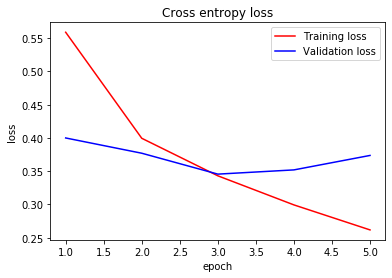

In [7]:
default_config = "content/snli_training.json"

script_dir = '/'
config = default_config
checkpoint = None

if config == default_config:
    config_path = os.path.join(script_dir, config)
else:
    config_path = config

with open(os.path.normpath(config_path), 'r') as config_file:
    config = json.load(config_file)

main(os.path.normpath(os.path.join(script_dir, config["train_data"])),
      os.path.normpath(os.path.join(script_dir, config["valid_data"])),
      os.path.normpath(os.path.join(script_dir, config["embeddings"])),
      os.path.normpath(os.path.join(script_dir, config["target_dir"])),
      config["hidden_size"],
      config["dropout"],
      config["num_classes"],
      config["epochs"],
      config["batch_size"],
      config["lr"],
      config["patience"],
      config["max_gradient_norm"],
      checkpoint)


In [0]:
"""
Test the model on some preprocessed dataset.
"""
# Aurelien Coet, 2018.

def test(model, dataloader):
    """
    Test the accuracy of a model on some labelled test dataset.

    Args:
        model: The torch module on which testing must be performed.
        dataloader: A DataLoader object to iterate over some dataset.

    Returns:
        batch_time: The average time to predict the classes of a batch.
        total_time: The total time to process the whole dataset.
        accuracy: The accuracy of the model on the input data.
    """
    # Switch the model to eval mode.
    model.eval()
    device = model.device

    time_start = time.time()
    batch_time = 0.0
    accuracy = 0.0

    # Deactivate autograd for evaluation.
    with torch.no_grad():
        for batch in dataloader:
            batch_start = time.time()

            # Move input and output data to the GPU if one is used.
            premises = batch["premise"].to(device)
            premises_lengths = batch["premise_length"].to(device)
            hypotheses = batch["hypothesis"].to(device)
            hypotheses_lengths = batch["hypothesis_length"].to(device)
            labels = batch["label"].to(device)

            _, probs = model(premises,
                             premises_lengths,
                             hypotheses,
                             hypotheses_lengths)

            accuracy += correct_predictions(probs, labels)
            batch_time += time.time() - batch_start

    batch_time /= len(dataloader)
    total_time = time.time() - time_start
    accuracy /= (len(dataloader.dataset))

    return batch_time, total_time, accuracy


def main_test(test_file, pretrained_file, batch_size=32):
    """
    Test the model with pretrained weights on some dataset.

    Args:
        test_file: The path to a file containing preprocessed NLI data.
        pretrained_file: The path to a checkpoint produced by the
            'train_model' script.
        vocab_size: The number of words in the vocabulary of the model
            being tested.
        embedding_dim: The size of the embeddings in the model.
        hidden_size: The size of the hidden layers in the model. Must match
            the size used during training. Defaults to 300.
        num_classes: The number of classes in the output of the model. Must
            match the value used during training. Defaults to 3.
        batch_size: The size of the batches used for testing. Defaults to 32.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print(20 * "=", " Preparing for testing ", 20 * "=")

    checkpoint = torch.load(pretrained_file)

    # Retrieving model parameters from checkpoint.
    vocab_size = checkpoint["model"]["_word_embedding.weight"].size(0)
    embedding_dim = checkpoint["model"]['_word_embedding.weight'].size(1)
    hidden_size = checkpoint["model"]["_projection.0.weight"].size(0)
    num_classes = checkpoint["model"]["_classification.4.weight"].size(0)

    print("\t* Loading test data...")
    with open(test_file, "rb") as pkl:
        test_data = NLIDataset(pickle.load(pkl))

    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

    print("\t* Building model...")
    model = DRLSTM(vocab_size,
                 embedding_dim,
                 hidden_size,
                 num_classes=num_classes,
                 device=device).to(device)

    model.load_state_dict(checkpoint["model"])

    print(20 * "=",
          " Testing model on device: {} ".format(device),
          20 * "=")
    batch_time, total_time, accuracy = test(model, test_loader)

    print("-> Average batch processing time: {:.4f}s, total test time:\
 {:.4f}s, accuracy: {:.4f}%".format(batch_time, total_time, (accuracy*100)))

In [9]:
test_data = '/content/test_data.pkl'
checkpoint = '/content/best.pth.tar'
batch_size = 32
main_test(test_data,
      checkpoint,
      batch_size)

====================  Preparing for testing  ====================
	* Loading test data...
	* Building model...
====================  Testing model on device: cuda:0  ====================


/content/drlstm/utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  sequences_lengths.new_tensor(torch.arange(0, len(sequences_lengths)))


-> Average batch processing time: 0.0283s, total test time: 8.7906s, accuracy: 86.5533%
